# Metadata

Author:   Qing Liu
Date:     04/30/2023
```

**Purpose:**  To implement PCA from scratch and explore application to Teaching Coaching transcripts
**OHCO: document_id, paragraph_id

# Set Up

## Config

In [57]:
data_in = "/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data/output"
data_out = "/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data/output"

In [58]:
#define ohco for BOW table
OHCO = ['document_id', 'paragraph_id']

In [59]:
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

We pick a color map for our gradient visualizations. For more info on color maps, see the [Matplotlib docs](https://matplotlib.org/stable/tutorials/colors/colormaps.html) on the subject.

In [60]:
# colors = "YlGnBu" 
colors = "Spectral"

## Import

In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

In [62]:
import plotly_express as px
import seaborn as sns

In [63]:
sns.set(style='ticks')

# Prepare the Data

## Import tables

In [64]:
LIB = pd.read_csv(f'{data_in}/LIB.csv').set_index('document_id')
VOCAB = pd.read_csv(f'{data_in}/VOCAB.csv').set_index('term_str')
BOW = pd.read_csv(f'{data_in}/BOW.csv').set_index(OHCO+['term_str'])

## Generate reduced `TFIDF` table

We reduce the feature space of the the TFIDF table by selecting the top 1000 significant nouns, verbs, and adjectives.

Note that the `TFIDF` table is an extension of an implied `DOC` table, where each doc is a chapter in this case.

In [65]:
# List of POS tags to keep
keep_pos = ['NN', 'NNS', 'NNP', 'NNPS',  # Nouns
            'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
            'JJ', 'JJR', 'JJS']  # Adjectives

In [66]:
BOW

n  tf_max_method  \
document_id         paragraph_id term_str                      
01_004_12c_001      1            classroom  1            1.0   
                                 five       1            1.0   
                                 lucas      1            1.0   
                                 minute     1            1.0   
                                 quick      1            1.0   
...                                        ..            ...   
03_2022_004_22c_083 15           students   1            0.5   
                                 talking    1            0.5   
                                 time       1            0.5   
                                 using      1            0.5   
                                 want       1            0.5   

                                            tfidf_max_method  tf_sum_method  \
document_id         paragraph_id term_str                                     
01_004_12c_001      1            classroom          3.631975       0.100000   
                                 five               5.963034       0.100000   
                                 lucas             11.940314       0.100000   
                                 minute             7.239874       0.100000   
                                 quick              5.831789       0.100000   
...                                                      ...            ...   
03_2022_004_22c_083 15           students           1.343824       0.032258   
                                 talking            1.825147       0.032258   
                                 time               1.616477       0.032258   
                                 using              2.318266       0.032258   
                                 want               1.224230       0.032258   

                                            tfidf_sum_method  tf_log_method  \
document_id         paragraph_id term_str                                     
01_004_12c_001      1            classroom          0.363197            1.0   
                                 five               0.596303            1.0   
                                 lucas              1.194031            1.0   
                                 minute             0.723987            1.0   
                                 quick              0.583179            1.0   
...                                                      ...            ...   
03_2022_004_22c_083 15           students           0.086698            1.0   
                                 talking            0.117751            1.0   
                                 time               0.104289            1.0   
                                 using              0.149566            1.0   
                                 want               0.078983            1.0   

                                            tfidf_log_method  
document_id         paragraph_id term_str                     
01_004_12c_001      1            classroom          3.631975  
                                 five               5.963034  
                                 lucas             11.940314  
                                 minute             7.239874  
                                 quick              5.831789  
...                                                      ...  
03_2022_004_22c_083 15           students           2.687648  
                                 talking            3.650295  
                                 time               3.232954  
                                 using              4.636533  
                                 want               2.448461  

[64128 rows x 7 columns]

In [67]:
TFIDF = BOW['tfidf_max_method'].unstack(fill_value=0) 
VSHORT = VOCAB[VOCAB.max_pos.isin(keep_pos)].sort_values('dfidf', ascending=False).head(1000)
TFIDF = TFIDF[VSHORT.index]

In [68]:
TFIDF

term_str                            think     going      want      know  \
document_id         paragraph_id                                          
01_004_12c_001      1             0.00000  0.000000  0.000000  0.000000   
                    2             0.00000  0.000000  0.000000  0.000000   
                    3             0.60626  0.000000  0.000000  0.000000   
                    4             0.00000  0.610117  0.612115  0.000000   
                    5             0.60626  0.000000  0.000000  0.838016   
...                                   ...       ...       ...       ...   
03_2022_004_22c_083 11            0.00000  0.000000  0.000000  0.000000   
                    12            0.90939  0.610117  2.448461  0.628512   
                    13            0.00000  1.220234  0.000000  0.000000   
                    14            0.90939  0.000000  1.836345  0.628512   
                    15            0.00000  2.440468  1.224230  0.000000   

term_str                               say  students   student  ethan  text  \
document_id         paragraph_id                                              
01_004_12c_001      1             0.000000  0.000000  0.000000    0.0   0.0   
                    2             0.000000  0.000000  0.000000    0.0   0.0   
                    3             0.000000  0.000000  0.950950    0.0   0.0   
                    4             0.000000  0.000000  0.000000    0.0   0.0   
                    5             0.000000  0.000000  0.000000    0.0   0.0   
...                                    ...       ...       ...    ...   ...   
03_2022_004_22c_083 11            0.000000  0.000000  0.000000    0.0   0.0   
                    12            0.654033  0.000000  0.713213    0.0   0.0   
                    13            0.000000  0.000000  0.000000    0.0   0.0   
                    14            1.962100  0.671912  0.713213    0.0   0.0   
                    15            1.308067  1.343824  0.000000    0.0   0.0   

term_str                              stop  ...  picked  fault  decide  \
document_id         paragraph_id            ...                          
01_004_12c_001      1             0.000000  ...     0.0    0.0     0.0   
                    2             0.000000  ...     0.0    0.0     0.0   
                    3             0.000000  ...     0.0    0.0     0.0   
                    4             0.000000  ...     0.0    0.0     0.0   
                    5             0.000000  ...     0.0    0.0     0.0   
...                                    ...  ...     ...    ...     ...   
03_2022_004_22c_083 11            2.986117  ...     0.0    0.0     0.0   
                    12            2.239588  ...     0.0    0.0     0.0   
                    13            0.000000  ...     0.0    0.0     0.0   
                    14            0.746529  ...     0.0    0.0     0.0   
                    15            2.986117  ...     0.0    0.0     0.0   

term_str                          foundation  guessing  tonight  maintain  \
document_id         paragraph_id                                            
01_004_12c_001      1                    0.0       0.0      0.0       0.0   
                    2                    0.0       0.0      0.0       0.0   
                    3                    0.0       0.0      0.0       0.0   
                    4                    0.0       0.0      0.0       0.0   
                    5                    0.0       0.0      0.0       0.0   
...                                      ...       ...      ...       ...   
03_2022_004_22c_083 11                   0.0       0.0      0.0       0.0   
                    12                   0.0       0.0      0.0       0.0   
                    13                   0.0       0.0      0.0       0.0   
                    14                   0.0       0.0      0.0       0.0   
                    15                   0.0       0.0      0.0       0.0   

term_str                       

# Begin PCA Process

## Normalize doc vector lengths

We use L2 normalization, which scales documents by their pythagorean (Euclidean) length.

In [69]:
# TFIDF_L2 = (TFIDF.T / np.sqrt(np.square(TFIDF).sum(axis=1))).T
TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

In [70]:
TFIDF_L2

term_str                             think     going      want      know  \
document_id         paragraph_id                                           
01_004_12c_001      1             0.000000  0.000000  0.000000  0.000000   
                    2             0.000000  0.000000  0.000000  0.000000   
                    3             0.077621  0.000000  0.000000  0.000000   
                    4             0.000000  0.084176  0.084451  0.000000   
                    5             0.057681  0.000000  0.000000  0.079730   
...                                    ...       ...       ...       ...   
03_2022_004_22c_083 11            0.000000  0.000000  0.000000  0.000000   
                    12            0.100975  0.067745  0.271868  0.069788   
                    13            0.000000  0.166184  0.000000  0.000000   
                    14            0.111135  0.000000  0.224416  0.076809   
                    15            0.000000  0.193010  0.096821  0.000000   

term_str                               say  students   student  ethan  text  \
document_id         paragraph_id                                              
01_004_12c_001      1             0.000000  0.000000  0.000000    0.0   0.0   
                    2             0.000000  0.000000  0.000000    0.0   0.0   
                    3             0.000000  0.000000  0.121752    0.0   0.0   
                    4             0.000000  0.000000  0.000000    0.0   0.0   
                    5             0.000000  0.000000  0.000000    0.0   0.0   
...                                    ...       ...       ...    ...   ...   
03_2022_004_22c_083 11            0.000000  0.000000  0.000000    0.0   0.0   
                    12            0.072621  0.000000  0.079192    0.0   0.0   
                    13            0.000000  0.000000  0.000000    0.0   0.0   
                    14            0.239784  0.082113  0.087160    0.0   0.0   
                    15            0.103451  0.106279  0.000000    0.0   0.0   

term_str                              stop  ...  picked  fault  decide  \
document_id         paragraph_id            ...                          
01_004_12c_001      1             0.000000  ...     0.0    0.0     0.0   
                    2             0.000000  ...     0.0    0.0     0.0   
                    3             0.000000  ...     0.0    0.0     0.0   
                    4             0.000000  ...     0.0    0.0     0.0   
                    5             0.000000  ...     0.0    0.0     0.0   
...                                    ...  ...     ...    ...     ...   
03_2022_004_22c_083 11            0.464254  ...     0.0    0.0     0.0   
                    12            0.248675  ...     0.0    0.0     0.0   
                    13            0.000000  ...     0.0    0.0     0.0   
                    14            0.091232  ...     0.0    0.0     0.0   
                    15            0.236163  ...     0.0    0.0     0.0   

term_str                          foundation  guessing  tonight  maintain  \
document_id         paragraph_id                                            
01_004_12c_001      1                    0.0       0.0      0.0       0.0   
                    2                    0.0       0.0      0.0       0.0   
                    3                    0.0       0.0      0.0       0.0   
                    4                    0.0       0.0      0.0       0.0   
                    5                    0.0       0.0      0.0       0.0   
...                                      ...       ...      ...       ...   
03_2022_004_22c_083 11                   0.0       0.0      0.0       0.0   
                    12                   0.0       0.0      0.0       0.0   
                    13                   0.0       0.0      0.0       0.0   
                    14                   0.0       0.0      0.0       0.0   
                    15                   0.0       0.0      0.0       0.0   

term_str          

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s–8m00s).

## Center the term vectors

We can take the column-wise means (the means for the _term_ vectors), but this alters the cosine angles between terms.

In [71]:
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

In [72]:
TFIDF_L2

term_str                             think     going      want      know  \
document_id         paragraph_id                                           
01_004_12c_001      1            -0.045530 -0.031675 -0.025568 -0.026811   
                    2            -0.045530 -0.031675 -0.025568 -0.026811   
                    3             0.032091 -0.031675 -0.025568 -0.026811   
                    4            -0.045530  0.052500  0.058883 -0.026811   
                    5             0.012151 -0.031675 -0.025568  0.052919   
...                                    ...       ...       ...       ...   
03_2022_004_22c_083 11           -0.045530 -0.031675 -0.025568 -0.026811   
                    12            0.055446  0.036070  0.246299  0.042976   
                    13           -0.045530  0.134509 -0.025568 -0.026811   
                    14            0.065605 -0.031675  0.198848  0.049998   
                    15           -0.045530  0.161334  0.071252 -0.026811   

term_str                               say  students   student     ethan  \
document_id         paragraph_id                                           
01_004_12c_001      1            -0.024568 -0.021443 -0.021295 -0.025466   
                    2            -0.024568 -0.021443 -0.021295 -0.025466   
                    3            -0.024568 -0.021443  0.100457 -0.025466   
                    4            -0.024568 -0.021443 -0.021295 -0.025466   
                    5            -0.024568 -0.021443 -0.021295 -0.025466   
...                                    ...       ...       ...       ...   
03_2022_004_22c_083 11           -0.024568 -0.021443 -0.021295 -0.025466   
                    12            0.048054 -0.021443  0.057898 -0.025466   
                    13           -0.024568 -0.021443 -0.021295 -0.025466   
                    14            0.215216  0.060670  0.065866 -0.025466   
                    15            0.078884  0.084837 -0.021295 -0.025466   

term_str                              text      stop  ...    picked     fault  \
document_id         paragraph_id                      ...                       
01_004_12c_001      1            -0.026701 -0.027563  ... -0.000474 -0.000438   
                    2            -0.026701 -0.027563  ... -0.000474 -0.000438   
                    3            -0.026701 -0.027563  ... -0.000474 -0.000438   
                    4            -0.026701 -0.027563  ... -0.000474 -0.000438   
                    5            -0.026701 -0.027563  ... -0.000474 -0.000438   
...                                    ...       ...  ...       ...       ...   
03_2022_004_22c_083 11           -0.026701  0.436691  ... -0.000474 -0.000438   
                    12           -0.026701  0.221112  ... -0.000474 -0.000438   
                    13           -0.026701 -0.027563  ... -0.000474 -0.000438   
                    14           -0.026701  0.063669  ... -0.000474 -0.000438   
                    15           -0.026701  0.208600  ... -0.000474 -0.000438   

term_str                            decide  foundation  guessing   tonight  \
document_id         paragraph_id                                             
01_004_12c_001      1            -0.000271    -0.00028 -0.000744 -0.000743   
                    2            -0.000271    -0.00028 -0.000744 -0.000743   
                    3            -0.000271    -0.00028 -0.000744 -0.000743   
                    4            -0.000271    -0.00028 -0.000744 -0.000743   
                    5            -0.000271    -0.00028 -0.000744 -0.000743   
...                                    ...         ...       ...       ...   
03_2022_004_22c_083 11           -0.000271    -0.00028 -0.000744 -0.000743   
                    12           -0.000271    -0.00028 -0.000744 -0.000743   
                    13           -0.000271    -0.00028 -0.000744 -0.000743   
                    14           -0.000271    -0.00028 -0.000744 -0.000743   
                    15          

## Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

We could we use the built in Pandas method here, but compute it ourselves.

In [73]:
COV = TFIDF_L2.cov()

In [74]:
COV

term_str          think     going      want      know       say      students  \
term_str                                                                        
think          0.012450 -0.000673 -0.000213 -0.000004  0.000110  2.006438e-04   
going         -0.000673  0.007698  0.000175 -0.000144  0.000171  1.232871e-04   
want          -0.000213  0.000175  0.004614  0.000420  0.000338  9.333691e-04   
know          -0.000004 -0.000144  0.000420  0.005750  0.000530  3.783543e-04   
say            0.000110  0.000171  0.000338  0.000530  0.005029  2.937805e-05   
...                 ...       ...       ...       ...       ...           ...   
tonight        0.000025 -0.000015 -0.000011 -0.000003 -0.000018 -7.018075e-06   
maintain       0.000007  0.000008  0.000007  0.000011  0.000003  1.757683e-05   
smaller       -0.000008  0.000004  0.000009  0.000008  0.000002  2.008162e-07   
interruptions  0.000007  0.000005 -0.000006 -0.000010  0.000010  7.631402e-06   
individual     0.000002 -0.000009 -0.000005 -0.000007  0.000002 -3.130510e-06   

term_str        student     ethan      text      stop  ...        picked  \
term_str                                               ...                 
think          0.000160 -0.000371  0.000431 -0.000874  ... -9.051041e-06   
going          0.000690  0.000469  0.000023  0.000438  ...  1.034479e-05   
want           0.000413  0.000438  0.000337  0.000532  ...  1.002624e-06   
know           0.000497  0.000066  0.000485 -0.000037  ...  2.020074e-06   
say            0.000476  0.000582  0.000527  0.000434  ... -2.261443e-06   
...                 ...       ...       ...       ...  ...           ...   
tonight       -0.000006 -0.000019 -0.000020 -0.000020  ... -3.522271e-07   
maintain       0.000009 -0.000002 -0.000007  0.000009  ... -1.251684e-07   
smaller       -0.000006 -0.000003 -0.000008  0.000002  ... -1.351114e-07   
interruptions -0.000007 -0.000012 -0.000012 -0.000013  ... -2.169980e-07   
individual     0.000028 -0.000002  0.000008 -0.000009  ... -1.515650e-07   

term_str              fault        decide    foundation      guessing  \
term_str                                                                
think          5.427573e-06 -2.347146e-06  2.073952e-06 -2.298334e-05   
going          2.142033e-06  1.456117e-05 -2.620943e-06 -1.527411e-05   
want           3.131241e-06  8.332223e-06  1.054826e-05 -1.486391e-05   
know           4.655109e-05  2.691465e-05  2.562694e-05  6.950355e-05   
say           -5.186063e-06  1.082336e-05  4.577892e-06 -1.127831e-06   
...                     ...           ...           ...           ...   
tonight       -3.256441e-07 -2.017361e-07 -2.085087e-07 -5.530793e-07   
maintain      -1.157218e-07 -7.168953e-08 -7.409625e-08 -1.965438e-07   
smaller       -1.249144e-07 -7.738431e-08 -7.998222e-08 -2.121567e-07   
interruptions -2.006209e-07 -1.242844e-07 -1.284568e-07 -3.407379e-07   
individual    -1.401262e-07 -8.680802e-08 -8.972229e-08 -2.379927e-07   

term_str            tonight      maintain       smaller  interruptions  \
term_str                                                                 
think          2.451264e-05  6.507526e-06 -8.380506e-06   6.811802e-06   
going         -1.544684e-05  7.572143e-06  4.053320e-06   5.493908e-06   
want          -1.087978e-05  6.503483e-06  9.377121e-06  -5.644533e-06   
know          -2.696570e-06  1.098389e-05  8.181564e-06  -1.009264e-05   
say           -1.826603e-05  3.314871e-06  1.975917e-06   1.018942e-05   
...                     ...           ...           ...            ...   
tonight        4.586823e-04 -1.963906e-07 -2.119913e-07  -3.404723e-07   
maintain      -1.963906e-07  5.350869e-05  8.041569e-06  -1.209912e-07   
smaller       -2.119913e-07  8.041569e-06  6.569336e-05  -1.306024e-07   
interruptions -3.404723e-07 -1.209912e-07 -1.306024e-07   1.772701e-04   
individual    -2.378072e-07 -8.450783e-08 -9.122086e-08  -1.465068e-07   

term_str         individual  
term_str      

## Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

In [75]:
from scipy.linalg import eigh

In [76]:
eig_vals, eig_vecs = eigh(COV)

## Convert eigen data to dataframes

In [77]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [78]:
EIG_VEC.iloc[:10, :10].style.background_gradient(cmap=colors)

## Explore Term Pairs

In [79]:
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']

In [80]:
# EIG_VEC_PAIRS['label'] = EIG_VEC_PAIRS.apply(lambda x: '-'.join(x.name), axis=1)

### Narratives descriptions

In [81]:
EIG_VEC_PAIRS.head(20)

covariance
term1       term2                
other's     think        0.912853
maintain    students     0.762015
perfect     solid        0.749172
personality going        0.706816
thank       guessing     0.694633
vader       want         0.628268
elements    um           0.578273
sorry       stem         0.569722
uh          bounce       0.564640
go          picked       0.553527
great       bat          0.541326
think       smaller      0.539886
hey         luke         0.534855
chocolate   say          0.532137
better      symbol       0.505630
good        picked       0.488206
closed      know         0.482376
wait        struggles    0.470517
ready       ava's        0.463740
nervous     running      0.460492

In [82]:
# px.scatter(EIG_VEC_PAIRS.sample(10000).sort_values('covariance'), y='label', x='covariance', height=1000)

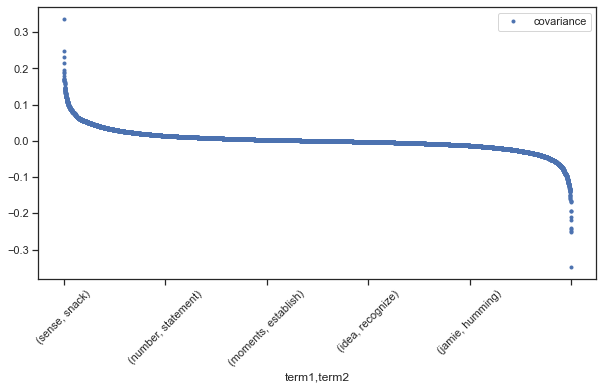

In [83]:
EIG_VEC_PAIRS.sample(10000).sort_values('covariance', ascending=False).plot(rot=45, style='.', figsize=(10,5));

## Select Principal Components

Next, we associate each eigenvalue with its corresponding *column* in the eigenvalue matrix. \
This is why we transpose the `EIG_VEC` dataframe.

## Combine eigenvalues and eignvectors

In [84]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [85]:
EIG_PAIRS.sort_values('eig_val', ascending=False).head(10)

eig_val     think     going      want      know       say  \
term_str                                                                    
individual     0.018929  0.332112 -0.036753 -0.052650  0.024287  0.009176   
interruptions  0.015849  0.268964 -0.193887 -0.189980 -0.122707 -0.142590   
smaller        0.014853  0.539886 -0.132280  0.089174  0.067625  0.052080   
maintain       0.013188  0.430021  0.095379  0.001998 -0.037410  0.062815   
tonight        0.012975 -0.123023 -0.300648 -0.104192 -0.022616  0.042983   
guessing       0.011260 -0.062716  0.071866 -0.075929 -0.140170 -0.088830   
foundation     0.010126  0.038208 -0.010293  0.024256 -0.024871  0.023303   
decide         0.009728 -0.161313 -0.105310  0.026175  0.035586 -0.034738   
fault          0.009461  0.008207  0.300180 -0.030284 -0.170161 -0.078997   
picked         0.009279  0.004246 -0.121689 -0.009072  0.012461  0.042007   

               students   student     ethan      text  ...    picked  \
term_str                                               ...             
individual     0.023839  0.046834 -0.183283  0.230084  ...  0.000190   
interruptions -0.138939 -0.147531 -0.183478 -0.259274  ... -0.001839   
smaller        0.105338  0.018144  0.056085  0.134734  ...  0.000808   
maintain      -0.058193  0.037102  0.225323 -0.132012  ... -0.001662   
tonight       -0.121586 -0.060363  0.041217 -0.096900  ...  0.000167   
guessing      -0.050949 -0.108172  0.008815  0.073906  ... -0.000670   
foundation     0.011117 -0.022510  0.119263  0.123957  ... -0.000478   
decide         0.060117 -0.050541  0.088439  0.114983  ...  0.000250   
fault         -0.037623 -0.082832  0.037129 -0.039746  ... -0.000831   
picked        -0.009623  0.006888  0.138204  0.108092  ... -0.001421   

                  fault    decide  foundation  guessing   tonight  maintain  \
term_str                                                                      
individual     0.000138 -0.001196   -0.000045  0.000346  0.000099 -0.000997   
interruptions -0.000828 -0.001555   -0.000782 -0.000746  0.005894 -0.000870   
smaller        0.001564  0.000866    0.001709  0.000669  0.001635  0.001242   
maintain      -0.000906 -0.000234   -0.000997 -0.004193 -0.001465  0.000776   
tonight       -0.000552 -0.001613   -0.001089 -0.000711 -0.000691 -0.001230   
guessing      -0.001497 -0.001110   -0.001364  0.000014  0.000485 -0.001103   
foundation    -0.000261 -0.000379   -0.001733 -0.000287  0.000028 -0.000644   
decide        -0.000492 -0.000885    0.001127  0.001708 -0.002079  0.000382   
fault         -0.001419  0.000183   -0.000954 -0.002639 -0.002636 -0.000863   
picked         0.000318 -0.000829   -0.000265 -0.003276 -0.001416 -0.001053   

                smaller  interruptions  individual  
term_str                                            
individual    -0.001376      -0.001038    0.000382  
interruptions -0.000456       0.000257   -0.000840  
smaller        0.000488       0.001059    0.001005  
maintain       0.000130      -0.000682   -0.001214  
tonight       -0.000247      -0.000804   -0.001261  
guessing      -0.000293      -0.001166   -0.000692  
foundation    -0.001213      -0.001840   -0.000214  
decide         0.000422      -0.002245   -0.000131  
fault         -0.000509      -0.000744   -0.000889  
picked        -0.000519      -0.001002   -0.000901  

[10 rows x 1001 columns]

Next, we sort in descending order and pick the top K (=10).

## Compute and Show Explained Variance

We might have usd this value to sort our components.

In [86]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

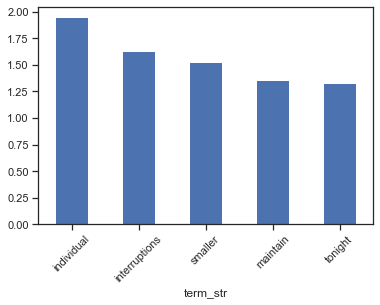

In [87]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45);

## Pick Top K (5) Components

We pick these based on explained variance.

In [88]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(5).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

In [89]:
COMPS

eig_val     think     going      want      know       say  students  \
pc_id                                                                         
PC0    0.018929  0.332112 -0.036753 -0.052650  0.024287  0.009176  0.023839   
PC1    0.015849  0.268964 -0.193887 -0.189980 -0.122707 -0.142590 -0.138939   
PC2    0.014853  0.539886 -0.132280  0.089174  0.067625  0.052080  0.105338   
PC3    0.013188  0.430021  0.095379  0.001998 -0.037410  0.062815 -0.058193   
PC4    0.012975 -0.123023 -0.300648 -0.104192 -0.022616  0.042983 -0.121586   

        student     ethan      text  ...     fault    decide  foundation  \
pc_id                                ...                                   
PC0    0.046834 -0.183283  0.230084  ...  0.000138 -0.001196   -0.000045   
PC1   -0.147531 -0.183478 -0.259274  ... -0.000828 -0.001555   -0.000782   
PC2    0.018144  0.056085  0.134734  ...  0.001564  0.000866    0.001709   
PC3    0.037102  0.225323 -0.132012  ... -0.000906 -0.000234   -0.000997   
PC4   -0.060363  0.041217 -0.096900  ... -0.000552 -0.001613   -0.001089   

       guessing   tonight  maintain   smaller  interruptions  individual  \
pc_id                                                                      
PC0    0.000346  0.000099 -0.000997 -0.001376      -0.001038    0.000382   
PC1   -0.000746  0.005894 -0.000870 -0.000456       0.000257   -0.000840   
PC2    0.000669  0.001635  0.001242  0.000488       0.001059    0.001005   
PC3   -0.004193 -0.001465  0.000776  0.000130      -0.000682   -0.001214   
PC4   -0.000711 -0.000691 -0.001230 -0.000247      -0.000804   -0.001261   

       exp_var  
pc_id           
PC0       1.95  
PC1       1.63  
PC2       1.53  
PC3       1.36  
PC4       1.33  

[5 rows x 1002 columns]

In [90]:
# COMPS.iloc[:,1:-1].T.sort_values('PC1', ascending=False).head(10).index

## See Projected Components onto Vocabulary (Loadings)

Loadings sow the contribution of each term to the component. \
We'll just look at the topi 10 words for the first two components in the Book version.

In [91]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

In [92]:
LOADINGS.head(5).style.background_gradient(cmap=colors)

In [96]:
LOADINGS.sort_values(by='PC0', ascending=False).style.background_gradient(cmap=colors)

In [97]:
top_terms = []
for i in range(5):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})

## Table of components and word counts

### Narratives 1: 
According to the Table of componets and words included in each component. The 1st component explained the most variance of the data. It has a evident pattern that the 1st principle component is positively correlated with words
that are from text_beased dicussion scenario, such as preservice teachers provides feedback to the avatar "Lisa" in the simulated classroom, while the 1st component is negatively correlated with behavior mangament scenario. For example, the negative columns include words of Ethan, talking, classroom, which refer to the Avatar Ethan perform those off-task behaviors (singing, humming, etch.), and perservices teachers are trying to redirect his behavior and build the classroom norms. So it seems the PCA is able to distinguish these two scenarios. 

On the other hand, the second component seems to play a role to differentiate the conversations between speaker 1 (coach) and speaker 2 (preservice teacher). The positive column includes words such as "feel", "sorry", "thank", "um", which are most likely from preservice teacher. And the negative column includes words such as "want", "ethan","stop", "students", "ask", which appears to refer to when coaches provide the training to those preservice teacher.

In [101]:
print("Table 1: Components and Top Words")
COMP_GLOSS

Table 1: Components and Top Words


1                                                      pos  \
comp_id                                                      
PC0      think lisa text nervous paragraph evidence cal...   
PC1      went think alright feel good simulation teache...   
PC2      think went good text evidence students um want...   
PC3      think stop lisa please ethan calm detector lie...   
PC4      paragraph says relaxed nervous heart smiled ch...   

1                                                      neg  
comp_id                                                     
PC0      stop please ethan talking classroom behavior n...  
PC1      text evidence going want ethan stop student as...  
PC2      feel lie detector brings results likely pismo ...  
PC3      go thank text evidence simulation questions gr...  
PC4      going simulation feel went alright evidence te...

In [40]:
COMP_GLOSS.loc['PC0','pos']

'think lisa text nervous paragraph evidence calm feeling lie detector'

In [41]:
COMP_GLOSS.loc['PC0','neg']

'stop please ethan talking classroom behavior norms whistling specific put'

In [42]:
COMP_GLOSS.loc['PC1','pos']

'went think alright feel good simulation teacher um sorry thank'

In [43]:
COMP_GLOSS.loc['PC1','neg']

'text evidence going want ethan stop student ask say students'

In [44]:
COMP_GLOSS.to_csv(f'{data_out}/PCA_COMP_WORD.csv')

In [45]:
# COMPS.join(COMP_GLOSS)

## Project Docs onto Components

We get the dot product of the DTM matrix and the new component matrix, which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [46]:
# We use the index to get only PC features, so matrices align
DCM = TFIDF_L2.dot(COMPS[COV.index].T) 

In [47]:
DCM

pc_id                                  PC0       PC1       PC2       PC3  \
document_id         paragraph_id                                           
01_004_12c_001      1            -0.069536  0.044104 -0.026455 -0.045984   
                    2            -0.143967  0.063365 -0.030188 -0.002329   
                    3             0.027037  0.073431  0.076350  0.002896   
                    4             0.017948 -0.118934  0.038998 -0.091910   
                    5             0.040254  0.010320  0.095746 -0.057096   
...                                    ...       ...       ...       ...   
03_2022_004_22c_083 11           -0.249249 -0.036604 -0.008720  0.150689   
                    12           -0.172700 -0.130790  0.088099  0.126395   
                    13           -0.202676 -0.030771 -0.039428  0.073802   
                    14           -0.112409 -0.100372  0.088726  0.029896   
                    15           -0.251581 -0.101452 -0.003616  0.087364   

pc_id                                  PC4  
document_id         paragraph_id            
01_004_12c_001      1             0.014824  
                    2             0.014380  
                    3            -0.032507  
                    4            -0.101666  
                    5            -0.076583  
...                                    ...  
03_2022_004_22c_083 11            0.080354  
                    12           -0.017636  
                    13            0.026024  
                    14           -0.071207  
                    15           -0.085238  

[3930 rows x 5 columns]

We add metadata to our new, reduced matrices for display purposes.

In [48]:
DCM = DCM.join(LIB[['site_id','scenario_id']], on='document_id')

In [49]:
DCM['label'] = DCM['site_id'] + ' ' + DCM['scenario_id']

We define a `doc` field to name each chapter.

In [50]:
DCM['doc'] = DCM['site_id'] + ' ' + DCM['scenario_id']+ '' + DCM.index.get_level_values('document_id').astype(str)

In [51]:
DCM.doc

document_id          paragraph_id
01_004_12c_001       1                    UVA QF01_004_12c_001
                     2                    UVA QF01_004_12c_001
                     3                    UVA QF01_004_12c_001
                     4                    UVA QF01_004_12c_001
                     5                    UVA QF01_004_12c_001
                                               ...            
03_2022_004_22c_083  11              RGV CN03_2022_004_22c_083
                     12              RGV CN03_2022_004_22c_083
                     13              RGV CN03_2022_004_22c_083
                     14              RGV CN03_2022_004_22c_083
                     15              RGV CN03_2022_004_22c_083
Name: doc, Length: 3930, dtype: object

In [52]:
DCM

PC0       PC1       PC2       PC3  \
document_id         paragraph_id                                           
01_004_12c_001      1            -0.069536  0.044104 -0.026455 -0.045984   
                    2            -0.143967  0.063365 -0.030188 -0.002329   
                    3             0.027037  0.073431  0.076350  0.002896   
                    4             0.017948 -0.118934  0.038998 -0.091910   
                    5             0.040254  0.010320  0.095746 -0.057096   
...                                    ...       ...       ...       ...   
03_2022_004_22c_083 11           -0.249249 -0.036604 -0.008720  0.150689   
                    12           -0.172700 -0.130790  0.088099  0.126395   
                    13           -0.202676 -0.030771 -0.039428  0.073802   
                    14           -0.112409 -0.100372  0.088726  0.029896   
                    15           -0.251581 -0.101452 -0.003616  0.087364   

                                       PC4 site_id scenario_id   label  \
document_id         paragraph_id                                         
01_004_12c_001      1             0.014824     UVA          QF  UVA QF   
                    2             0.014380     UVA          QF  UVA QF   
                    3            -0.032507     UVA          QF  UVA QF   
                    4            -0.101666     UVA          QF  UVA QF   
                    5            -0.076583     UVA          QF  UVA QF   
...                                    ...     ...         ...     ...   
03_2022_004_22c_083 11            0.080354     RGV          CN  RGV CN   
                    12           -0.017636     RGV          CN  RGV CN   
                    13            0.026024     RGV          CN  RGV CN   
                    14           -0.071207     RGV          CN  RGV CN   
                    15           -0.085238     RGV          CN  RGV CN   

                                                        doc  
document_id         paragraph_id                             
01_004_12c_001      1                  UVA QF01_004_12c_001  
                    2                  UVA QF01_004_12c_001  
                    3                  UVA QF01_004_12c_001  
                    4                  UVA QF01_004_12c_001  
                    5                  UVA QF01_004_12c_001  
...                                                     ...  
03_2022_004_22c_083 11            RGV CN03_2022_004_22c_083  
                    12            RGV CN03_2022_004_22c_083  
                    13            RGV CN03_2022_004_22c_083  
                    14            RGV CN03_2022_004_22c_083  
                    15            RGV CN03_2022_004_22c_083  

[3930 rows x 9 columns]

In [53]:
DCM.to_csv(f'{data_out}/PCA_DOCU_COMP.csv')

# Visualize

In [108]:
def vis_pcs(M, a, b, label='scenario_id', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=500, width=700)
    fig.show()

In [55]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=600, width=800)

## PC 0 and 1

### Interpretation:
This plot projects each document onto the first and second components derived from principal component analysis. It is clear that the first component effectively distinguishes documents into two clusters, which align with each document's scenario (e.g., quality of feedback, classroom norms). From the plot, we observe that the quality of feedback (QF) documents are dispersed on the right side, whereas the classroom norms (CN) documents are dispersed on the left side. This further confirms that the first component is positively correlated with the text-based discussion scenario and negatively correlated with the classroom norm scenario.

Regarding the second component depicted on the y-axis, it is evident that the majority of documents are concentrated towards the bottom, with fewer documents situated at the top. This observation is consistent with the fact that each transcript contains a higher proportion of coach discussions due to the intervention's nature. Furthermore, it is apparent that the quality of feedback (QF) scenario exhibits greater dispersion along the second component compared to the classroom norms (CN) scenario. This phenomenon also aligns with the expectation that text-based discussions would involve a broader range of conversations between coaches and preservice teachers.


### Scenario

In [113]:
print("Figure 1. Scatter plot of document on the aixs of 1st and 2nd components")
vis_pcs(DCM, 0, 1)

Figure 1. Scatter plot of document on the aixs of 1st and 2nd components


### Loadings

In [110]:
vis_loadings(0,1)

In [111]:
vis_pcs(DCM, 0, 1, label='site_id')

### Interpretation:
In the context of PCA, the text-based discussion conversations from RGV and SMU sites exhibit greater similarity in terms of distribution along the 1st component, while those from the UVA site demonstrate a higher degree of variation.

Interestingly, when it comes to the classroom norm conversations, RGV and UVA display a more comparable distribution, while SMU exhibits less variation.

In [114]:
print("Figure 2. Documents by study site and scenario")
vis_pcs(DCM, 0, 1, label='label')

Figure 2. Documents by study site and scenario


## Dendrograms

In [214]:
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram # Built on top SciPy

In [215]:
import sys
sys.path.append("/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/lib")
from hac import HAC

In [216]:
LIB = LIB.reset_index()

In [217]:
LIB['label'] = LIB['site_id'] + "-" + LIB['scenario_id'] + "-" + LIB['document_id']

In [218]:
LIB = LIB.set_index('document_id')

In [219]:
LIB 

File Path site_id  \
document_id                                                                 
02_004_22c_100  /Users/poppy/Documents/TeachSim Project/Robert...     SMU   
02_004_22c_074  /Users/poppy/Documents/TeachSim Project/Robert...     SMU   
02_004_22c_061  /Users/poppy/Documents/TeachSim Project/Robert...     SMU   
02_004_22c_049  /Users/poppy/Documents/TeachSim Project/Robert...     SMU   
02_004_32c_014  /Users/poppy/Documents/TeachSim Project/Robert...     SMU   
...                                                           ...     ...   
01_004_12c_022  /Users/poppy/Documents/TeachSim Project/Robert...     UVA   
01_004_12c_023  /Users/poppy/Documents/TeachSim Project/Robert...     UVA   
01_004_12c_037  /Users/poppy/Documents/TeachSim Project/Robert...     UVA   
01_004_12c_035  /Users/poppy/Documents/TeachSim Project/Robert...     UVA   
01_004_12c_008  /Users/poppy/Documents/TeachSim Project/Robert...     UVA   

               scenario_id  doc_length  n_paragraph  n_word  \
document_id                                                   
02_004_22c_100          CN         804           12     283   
02_004_22c_074          CN        1093           17     355   
02_004_22c_061          CN        1033           22     318   
02_004_22c_049          CN        1012           35     324   
02_004_32c_014          CN        1102           21     342   
...                    ...         ...          ...     ...   
01_004_12c_022          QF         897           10     271   
01_004_12c_023          QF         842           15     268   
01_004_12c_037          QF        1010           36     285   
01_004_12c_035          QF        1268           50     338   
01_004_12c_008          QF        1082           26     320   

                                label  
document_id                            
02_004_22c_100  SMU-CN-02_004_22c_100  
02_004_22c_074  SMU-CN-02_004_22c_074  
02_004_22c_061  SMU-CN-02_004_22c_061  
02_004_22c_049  SMU-CN-02_004_22c_049  
02_004_32c_014  SMU-CN-02_004_32c_014  
...                               ...  
01_004_12c_022  UVA-QF-01_004_12c_022  
01_004_12c_023  UVA-QF-01_004_12c_023  
01_004_12c_037  UVA-QF-01_004_12c_037  
01_004_12c_035  UVA-QF-01_004_12c_035  
01_004_12c_008  UVA-QF-01_004_12c_008  

[214 rows x 7 columns]

In [220]:
X = DCM[COMPS.index].groupby('document_id').mean()
titles = LIB.loc[list(X.index)].apply(lambda x: x.label, 1)
X.index = titles

In [221]:
X

PC0       PC1       PC2       PC3       PC4
UVA-QF-01_004_12c_001       0.052134 -0.049496 -0.008689 -0.052209  0.031590
UVA-QF-01_004_12c_003       0.166588 -0.052148 -0.027387  0.019745  0.009958
UVA-QF-01_004_12c_008       0.093052 -0.009524 -0.033976 -0.019703  0.010297
UVA-QF-01_004_12c_017       0.167327 -0.007868 -0.019859  0.055600  0.005465
UVA-QF-01_004_12c_022       0.033523  0.003077  0.030954 -0.051738 -0.004876
...                              ...       ...       ...       ...       ...
RGV-CN-03_2022_004_22c_058 -0.084806  0.013990 -0.019045 -0.002337 -0.022228
RGV-CN-03_2022_004_22c_064 -0.081280  0.024048  0.031252  0.019355 -0.007854
RGV-CN-03_2022_004_22c_067 -0.101922  0.001329 -0.000740  0.019276 -0.007349
RGV-CN-03_2022_004_22c_069 -0.068751  0.027752 -0.019722 -0.013517  0.031825
RGV-CN-03_2022_004_22c_083 -0.121751  0.004266  0.041941  0.064603 -0.005891

[214 rows x 5 columns]

In [222]:
X.style.background_gradient(cmap=colors)

<Figure size 432x288 with 0 Axes>

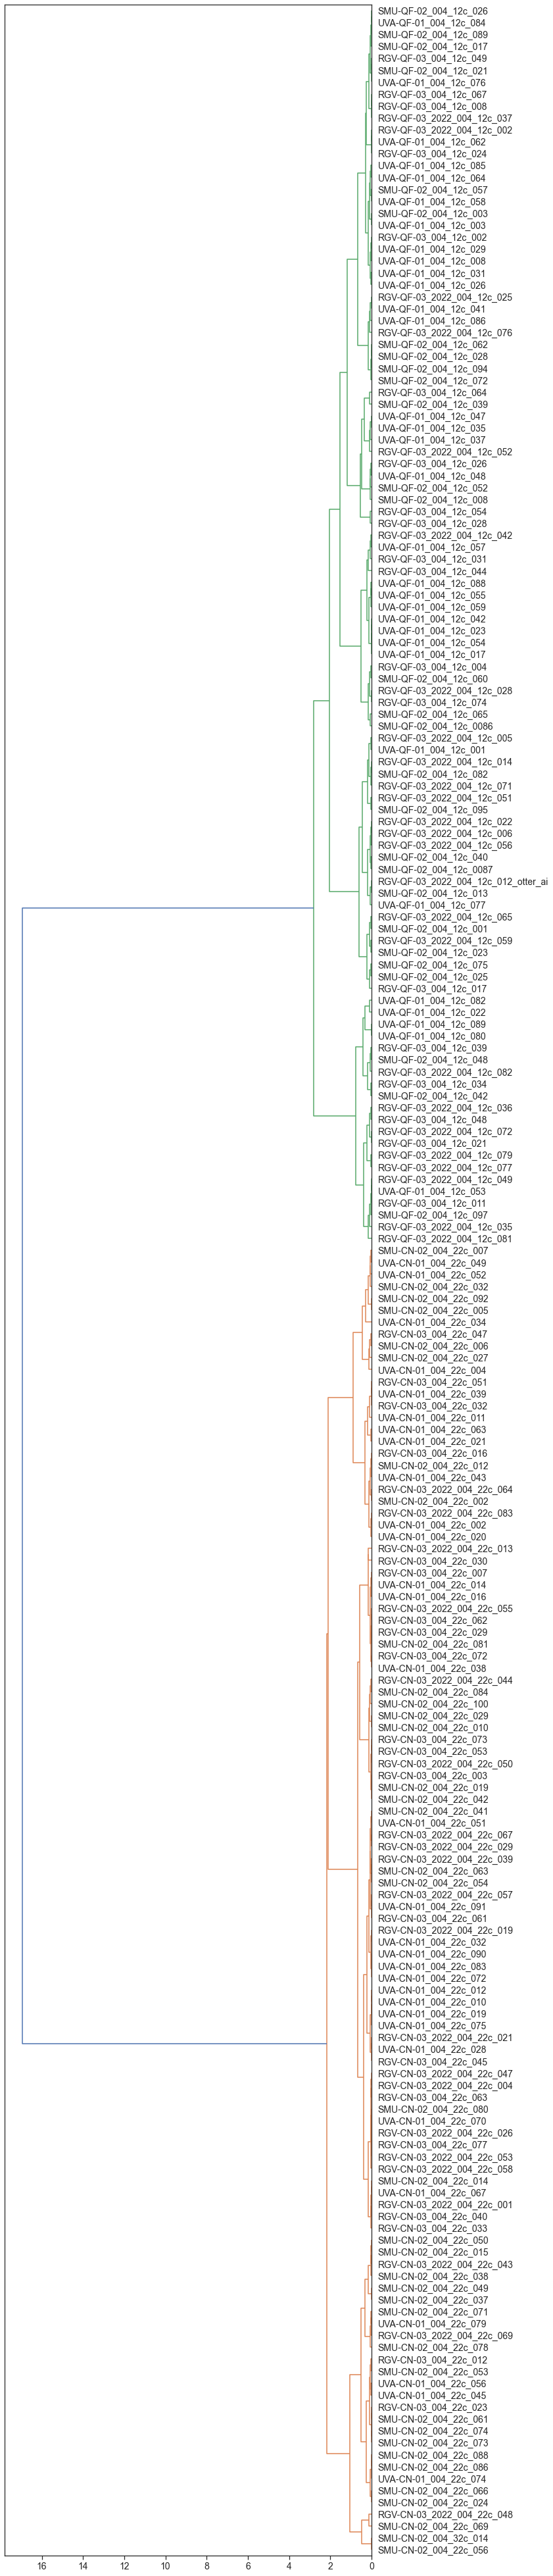

In [223]:
HAC(X).plot();

In [117]:
# fig = create_dendrogram(X, labels=X.index, orientation='left', color_threshold=.3)
# fig.update_layout(width=1000, height=800)
# fig.show()

In [224]:
XV = LOADINGS.loc[VSHORT.sort_values('dfidf', ascending=False).head(100).index]

<Figure size 432x288 with 0 Axes>

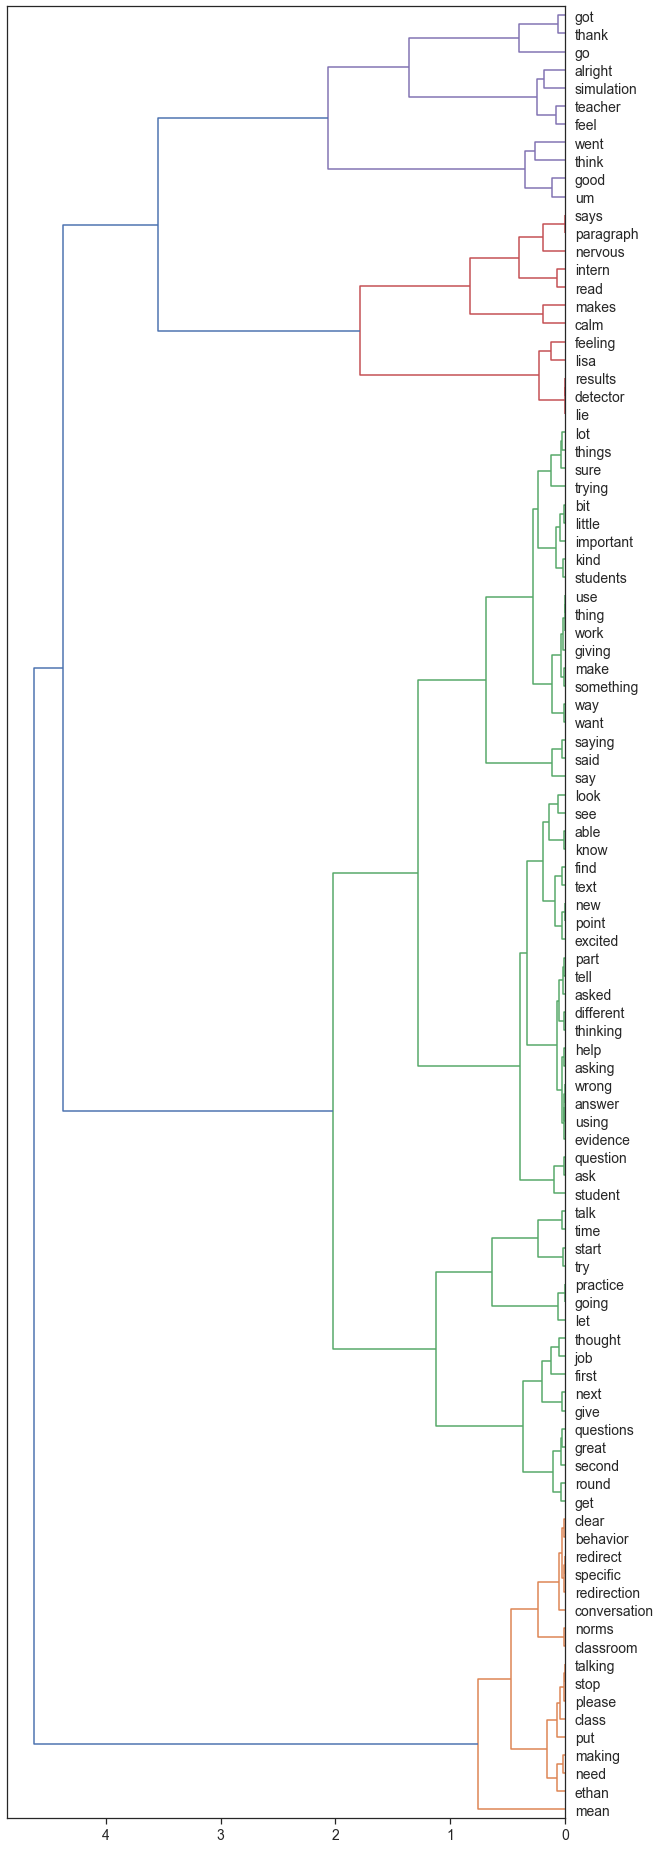

In [225]:
HAC(XV).plot()

In [226]:
# fig = create_dendrogram(XV, labels=XV.index, orientation='left', color_threshold=.05)
# fig.update_layout(width=1000, height=1200)
# fig.show()

In [227]:
XV2 = LOADINGS.loc[VSHORT.sample(50).index]

<Figure size 432x288 with 0 Axes>

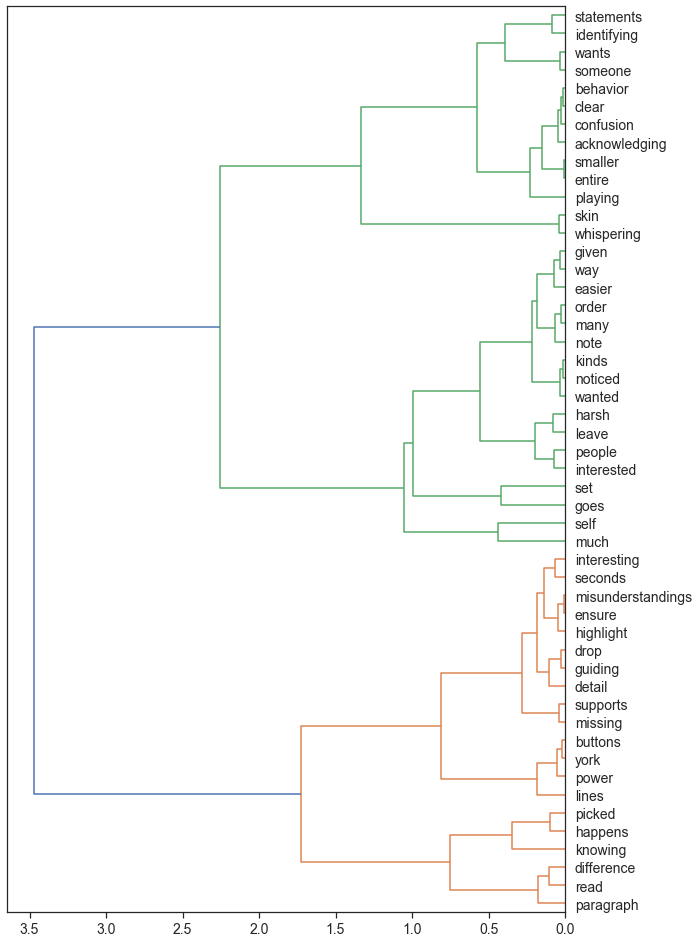

In [228]:
HAC(XV2).plot()

In [78]:
# fig = create_dendrogram(XV2, labels=XV2.index, orientation='left', color_threshold=.05)
# fig.update_layout(width=1000, height=1200)
# fig.show()

# SAVE

In [231]:
LOADINGS

pc_id               PC0       PC1       PC2       PC3       PC4
term_str                                                       
think          0.332112  0.268964  0.539886  0.430021 -0.123023
going         -0.036753 -0.193887 -0.132280  0.095379 -0.300648
want          -0.052650 -0.189980  0.089174  0.001998 -0.104192
know           0.024287 -0.122707  0.067625 -0.037410 -0.022616
say            0.009176 -0.142590  0.052080  0.062815  0.042983
...                 ...       ...       ...       ...       ...
tonight        0.000099  0.005894  0.001635 -0.001465 -0.000691
maintain      -0.000997 -0.000870  0.001242  0.000776 -0.001230
smaller       -0.001376 -0.000456  0.000488  0.000130 -0.000247
interruptions -0.001038  0.000257  0.001059 -0.000682 -0.000804
individual     0.000382 -0.000840  0.001005 -0.001214 -0.001261

[1000 rows x 5 columns]

In [233]:
TFIDF.to_csv(f'{data_out}/TFIDF_para.csv')
TFIDF_L2.to_csv(f'{data_out}/TFIDF_para_L2.csv')
COMP_GLOSS.to_csv(f'{data_out}/PCA_COMP_WORD.csv')
DCM.to_csv(f'{data_out}/PCA_DOCU_COMP.csv')
LOADINGS.to_csv(f'{data_out}/PCA_LOADINGS.csv')